# Inference

This notebook enables to predict the closest images of a sketch. 

In [48]:
# Imports
import json
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import pandas as pd
from PIL import Image
import torch
from torchvision import transforms
from torch.utils.data import DataLoader

plt.rcParams["figure.figsize"] = (12,12)
plt.rcParams['axes.titlesize'] = 15

In [49]:
from src.data.constants import DatasetName, Split
from src.data.loader_factory import load_data
from src.data.utils import default_image_loader, default_image_loader_tuberlin, get_loader, get_dict
from src.models.encoder import EncoderCNN
from src.models.utils import load_checkpoint, get_model
from src.models.test import get_test_data
from src.models.metrics import get_similarity
from src.models.logs import normalise_attention

In [50]:
class Args:
    dataset = DatasetName.sketchy
    data_path = "../io/data/raw"
    emb_size = 256
    grl_lambda = 0.5
    nopretrain = False
    epochs = 1000
    batch_size = 10
    seed = 42
    load = None
    early_stop = 20
    ngpu = 1
    prefetch = 2
    log = "../io/models/"
    log_interval = 20
    attn = True
    plot = False
    cuda = False
    save = ''
    load_embeddings = '../io/data/processed/embeddings.ending'
    best_model = '../io/models/best_model/checkpoint.pth'
    #best_model = '../io/models/0_run-batch_size_10/checkpoint.pth'
    training_split = 0.8
    valid_split = 0.1
    
args = Args()

In [51]:
NUM_CLOSEST = 4

## Inference

In [52]:
class Inference():
    ''' Class to infer closest images of a sketch '''

    def __init__(self, args, dataset_type):
        '''
        Initialises the inference with the trained model and precomputed embeddings
        Args:
            - args: arguments reveived from the command line (argparse)
            - dataset_type: dataset split ('train', 'valid' or 'test')
        '''
        self.args = args
        self.transform = transforms.Compose([transforms.ToTensor()])
        self.loader = default_image_loader

        self.im_net, self.sk_net = get_model(args, args.best_model)
        self.im_net.eval()
        self.sk_net.eval()
        torch.set_grad_enabled(False)

        self.prediction_folder = os.path.join(args.best_model.rstrip('checkpoint.pth'), 'predictions')
        if not os.path.exists(self.prediction_folder):
            os.makedirs(self.prediction_folder)

        self.embedding_path = os.path.join(args.best_model.rstrip('checkpoint.pth'), 'precomputed_embeddings')
        if not os.path.exists(self.embedding_path):
            os.makedirs(self.embedding_path)

        self.get_data(dataset_type)

    def get_processed_images(self, args, dataset_type):
        '''
        Get the data of images to match with the sketches
        Args:
            - args: arguments reveived from the command line (argparse)
            - dataset_type: dataset split ('train', 'valid' or 'test')
        Return:
            - dict_class: dictionnary mapping numbers to classes names
            - paths to the images
            - classes of the images
            - images_embeddings: embeddings of the images
        '''
        dict_path = os.path.join(self.embedding_path, args.dataset + '_dict_class.json')
        with open(dict_path, 'r') as fp:
            dict_class = json.load(fp)

        array_path = os.path.join(self.embedding_path, args.dataset + '_' + dataset_type + '_array.npy')
        with open(array_path, 'rb') as f:
            images_embeddings = np.load(f)

        meta_path = os.path.join(self.embedding_path, args.dataset + '_' + dataset_type + '_meta.csv')
        df = pd.read_csv(meta_path, sep=' ')

        return dict_class, df['fnames'].values, df['classes'].values, images_embeddings

    def get_data(self, dataset_type):
        '''
        Loads the paths, classes and embeddings of the images of different datasets
        '''
        dataset = self.args.dataset

        if dataset in [DatasetName.sketchy, DatasetName.tuberlin, DatasetName.quickdraw]:
            (self.dict_class, self.images_fnames,
             self.images_classes, self.images_embeddings) = self.get_processed_images(self.args, dataset_type)
            self.sketchy_limit = None
            self.tuberlin_limit = None

        elif dataset in [DatasetName.sktu, DatasetName.sktuqd]:
            self.args.dataset = DatasetName.sketchy
            dict_class_sk, self.images_fnames, self.images_classes, self.images_embeddings = self.get_processed_images(
                self.args, dataset_type)

            self.sketchy_limit = len(self.images_fnames)
            self.tuberlin_limit = None

            self.args.dataset = DatasetName.tuberlin
            dict_class_tu, images_fnames, images_classes, images_embeddings = self.get_processed_images(
                self.args, dataset_type)
            self.dict_class = [dict_class_sk, dict_class_tu]

            self.images_fnames = np.concatenate((self.images_fnames, images_fnames), axis=0)
            self.images_classes = np.concatenate((self.images_classes, images_classes), axis=0)
            self.images_embeddings = np.concatenate((self.images_embeddings, images_embeddings), axis=0)

            if dataset == DatasetName.sktuqd:
                self.args.dataset = DatasetName.quickdraw
                self.tuberlin_limit = len(self.images_fnames)

                dict_class_qd, images_fnames, images_classes, images_embeddings = self.get_processed_images(
                    self.args, dataset_type)
                self.dict_class.append(dict_class_qd)

                self.images_fnames = np.concatenate((self.images_fnames, images_fnames), axis=0)
                self.images_classes = np.concatenate((self.images_classes, images_classes), axis=0)
                self.images_embeddings = np.concatenate((self.images_embeddings, images_embeddings), axis=0)
        else:
            raise Exception(args.dataset + ' not implemented.')
        self.args.dataset = dataset

    def random_images_inference(self, args, number_sketches):
        ''' Selects number_sketches random sketched and find the closest images '''
        _, _, [test_sk_loader, _], _ = load_data(args, self.transform)
        rand_samples_sk = np.random.randint(0, high=len(test_sk_loader), size=number_sketches)

        for i in range(len(rand_samples_sk)):
            _, sketch_fname, _ = test_sk_loader[rand_samples_sk[i]]
            self.inference_sketch(sketch_fname)
            self.plot_closest(sketch_fname)

    def inference_sketch(self, sketch_fname):
        ''' Find the closest images of a sketch and plot it '''
        sketch = self.transform(self.loader(sketch_fname)).unsqueeze(0)  # unsqueeze because 1 sketch (no batch)

        if self.args.cuda:
            sketch = sketch.cuda()
        sketch_embedding, attn_sk = self.sk_net(sketch)
        self.attn_sk = normalise_attention(attn_sk, sketch)

        if self.args.cuda:
            sketch_embedding = sketch_embedding.cpu()
        self.get_closest_images(sketch_embedding)

    def get_closest_images(self, sketch_embedding):
        '''
        Based on a sketch embedding, retrieve the index of the closest images
        '''
        similarity = get_similarity(sketch_embedding.detach().numpy(), self.images_embeddings)
        arg_sorted_sim = (-similarity).argsort()

        self.sorted_fnames = [self.images_fnames[i]
                              for i in arg_sorted_sim[0][0:NUM_CLOSEST + 1]]
        self.sorted_labels = [self.images_classes[i]
                              for i in arg_sorted_sim[0][0:NUM_CLOSEST + 1]]

    def prepare_image(self, index):
        dataset = self.sorted_fnames[index].split('/')[-4]

        loader = get_loader(dataset)
        image = loader('../' + self.sorted_fnames[index])

        dict_class = get_dict(dataset, self.dict_class)
        label = dict_class[str(self.sorted_labels[index])]
        return image, label

    def return_closest_images(self, number):
        images, labels = [], []
        for index in range(number):
            image, label = self.prepare_image(index)
            images.append(image)
            labels.append(label)

        return images, labels

    def plot_closest(self, sketch_fname):
        '''
        Plots a sketch with its closest images in the embedding space.
        The images are stored in the same folder as the best model in a subfolder called 'predictions'
        '''
        fig, axes = plt.subplots(1, NUM_CLOSEST + 2, figsize=((NUM_CLOSEST+1)*4, 8))

        sk = mpimg.imread(sketch_fname)
        axes[0].imshow(sk)
        axes[0].set(title='Sketch \n Label: ' + sketch_fname.split('/')[-2])
        axes[0].axis('off')
        
        heat_map = self.attn_sk.squeeze().detach().numpy()
        axes[1].imshow(sk)
        axes[1].imshow(255 * heat_map, alpha=0.7, cmap='Spectral_r')
        axes[1].set(title= sketch_fname.split('/')[-2] +'\n Attention Map')
        axes[1].axis('off')

        for i in range(2, NUM_CLOSEST + 2):
            im, label = self.prepare_image(i-1)
            axes[i].imshow(im)
            axes[i].set(title='Closest image ' + str(i) +
                        '\n Label: ' + label)

            axes[i].axis('off')
        plt.subplots_adjust(wspace=0.25, hspace=-0.35)

        img_name = '_'.join(sketch_fname.split('/')[-2:])
        plt.savefig(os.path.join(self.prediction_folder, img_name))

In [53]:
args.dataset = DatasetName.sketchy
inference_test = Inference(args, Split.test)

# Resuts per multiple randomly selected images

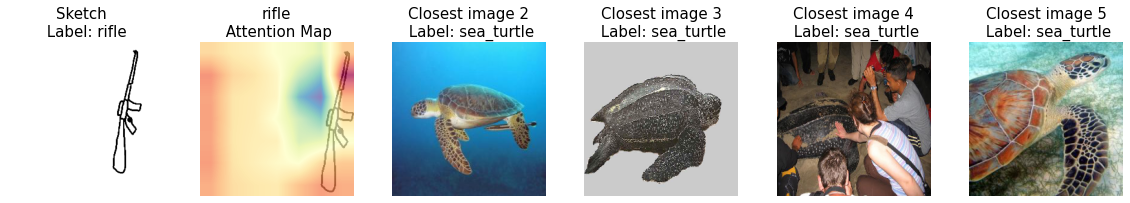

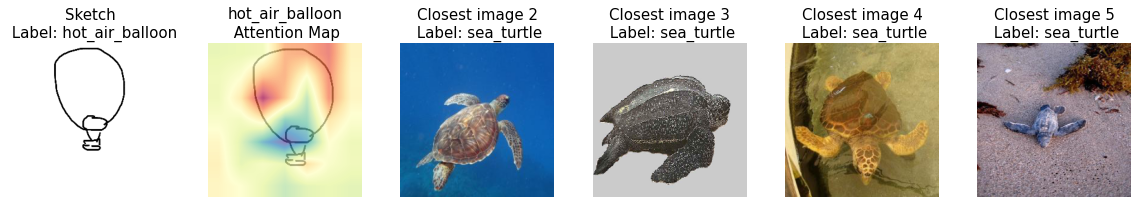

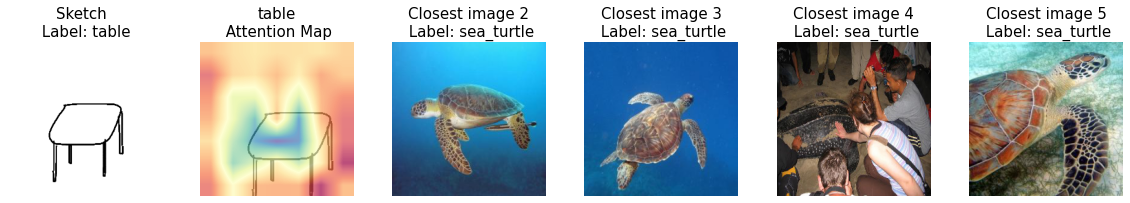

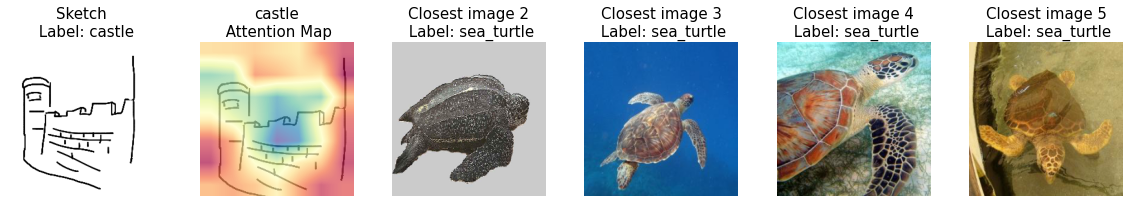

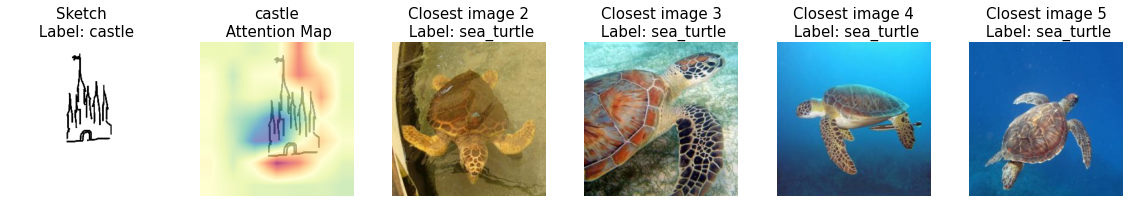

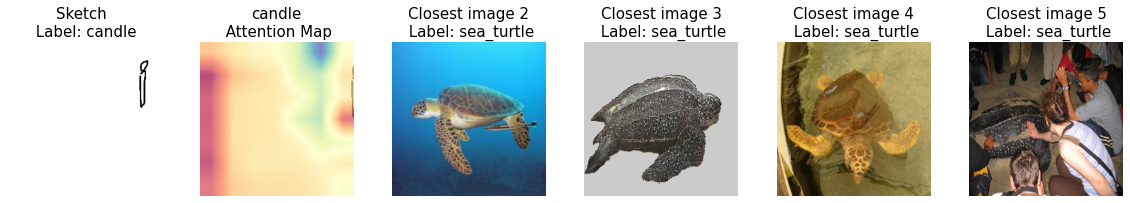

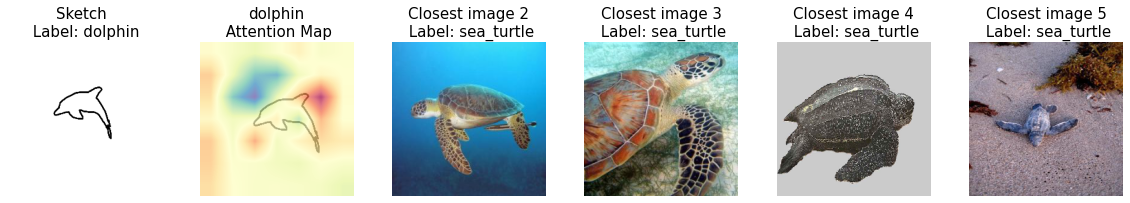

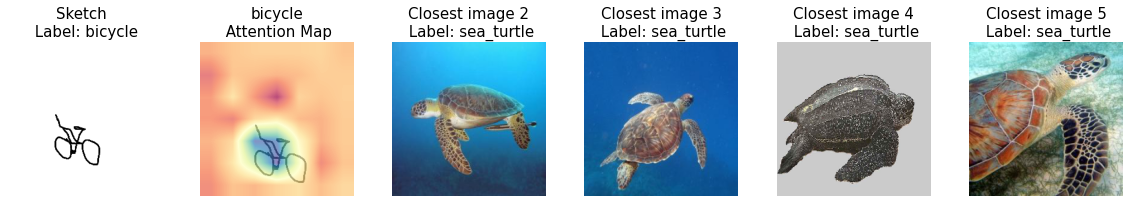

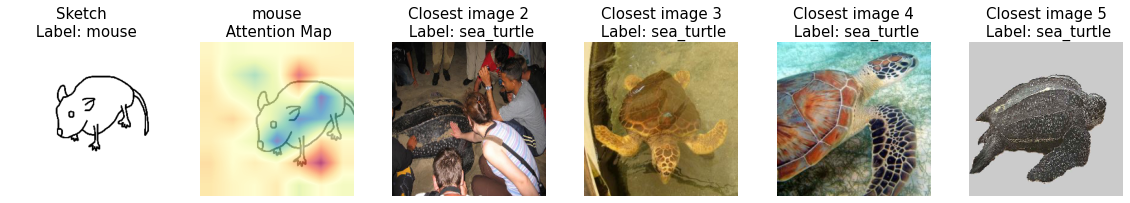

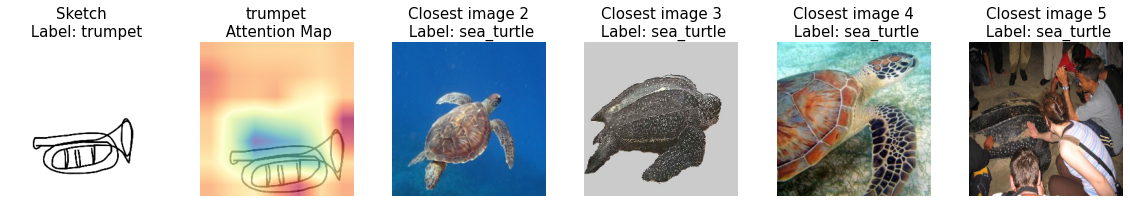

In [54]:
inference_test.random_images_inference(args, number_sketches=10)

# Results per 1 image

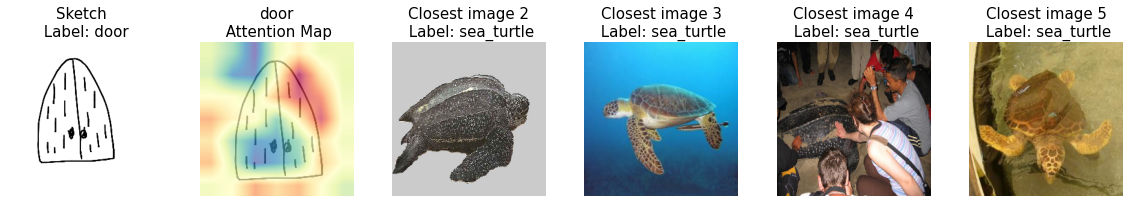

In [54]:
sketch_fname = '../io/data/raw/Sketchy/sketches/door/n03222176_681-1.png'
inference_test.inference_sketch(sketch_fname)
inference_test.plot_closest(sketch_fname)

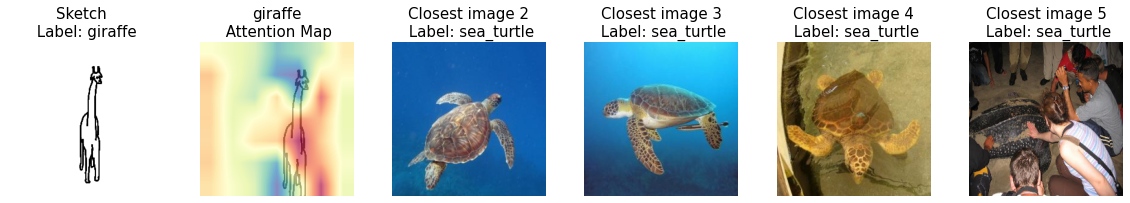

In [55]:
sketch_fname = '../io/data/raw/Sketchy/sketches/giraffe/n02439033_67-1.png'
inference_test.inference_sketch(sketch_fname)
inference_test.plot_closest(sketch_fname)

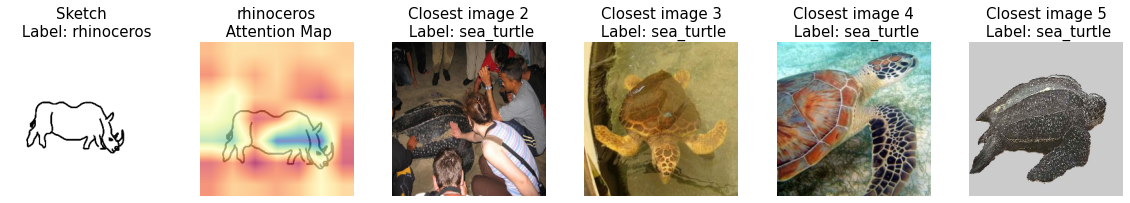

In [56]:
sketch_fname = '../io/data/raw/Sketchy/sketches/rhinoceros/n02391994_135-1.png'
inference_test.inference_sketch(sketch_fname)
inference_test.plot_closest(sketch_fname)

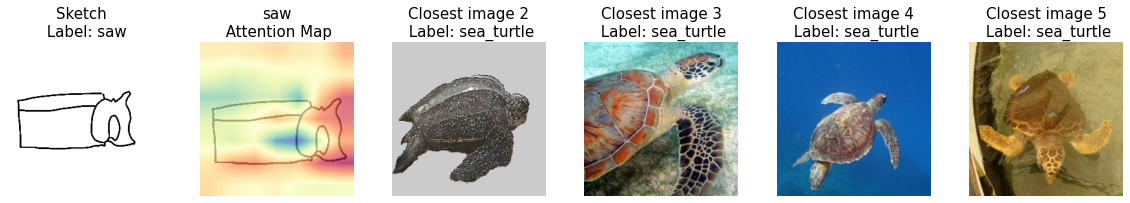

In [57]:
sketch_fname = '../io/data/raw/Sketchy/sketches/saw/n02770585_1371-1.png'
inference_test.inference_sketch(sketch_fname)
inference_test.plot_closest(sketch_fname)

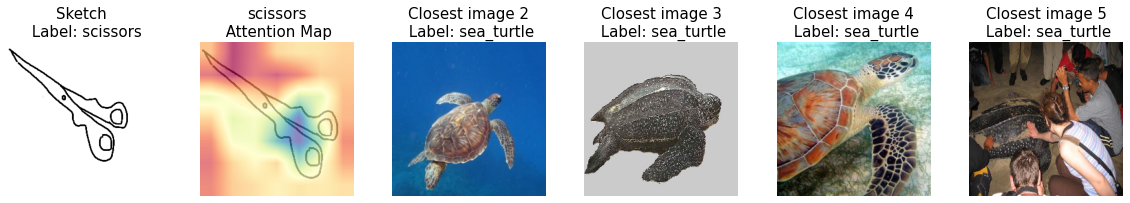

In [58]:
sketch_fname = '../io/data/raw/Sketchy/sketches/scissors/n03044934_5634-1.png'
inference_test.inference_sketch(sketch_fname)
inference_test.plot_closest(sketch_fname)

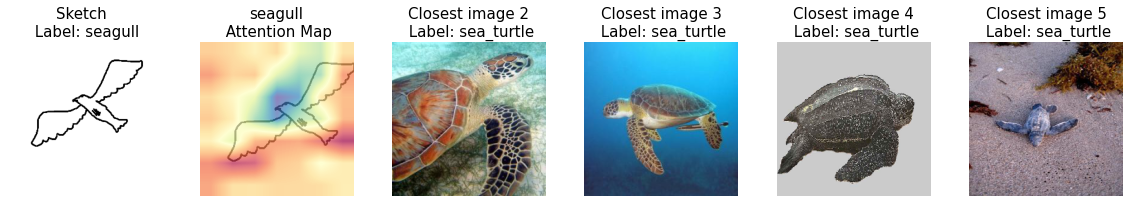

In [59]:
sketch_fname = '../io/data/raw/Sketchy/sketches/seagull/n02041246_30-1.png'
inference_test.inference_sketch(sketch_fname)
inference_test.plot_closest(sketch_fname)

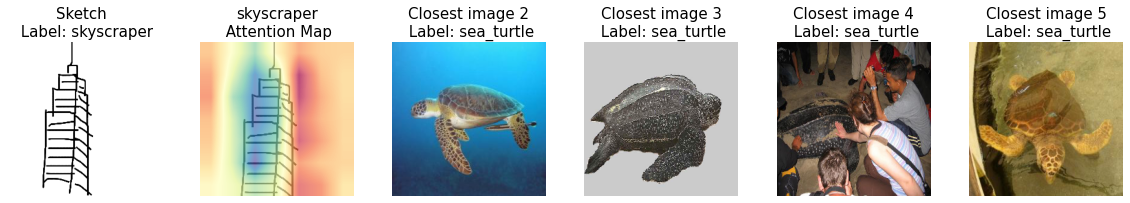

In [60]:
sketch_fname = '../io/data/raw/Sketchy/sketches/skyscraper/n04233124_498-1.png'
inference_test.inference_sketch(sketch_fname)
inference_test.plot_closest(sketch_fname)

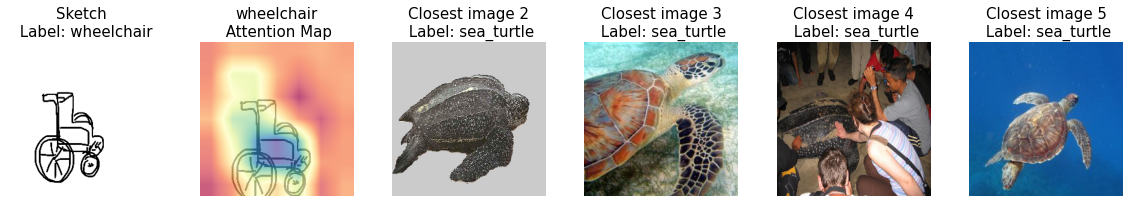

In [61]:
sketch_fname = '../io/data/raw/Sketchy/sketches/wheelchair/n04576002_150-2.png'
inference_test.inference_sketch(sketch_fname)
inference_test.plot_closest(sketch_fname)